# TCC Ciência de Dados e Big Data - PUC Minas

**Contexto:** *A importância da educação básica no Brasil e os desafios enfrentados nos municípios da região Nordeste.*

**Problema Proposto:** *Identificar os fatores que mais influenciam na taxa de aprovação do ensino fundamental nos municípios da Região Nordeste do Brasil.*

**Objetivos:** *Analisar a taxa de aprovação escolar utilizando dados do Censo Escolar e Indicadores Educacionais, identificar fatores de influência*

**Fonte dos dados:** *Base de dados do Censo Escolar do Inep, Indicadores Educacionais do Inep, SICONFI, Dados do IBGE e Diretórios Brasil disponibilizada e tratada pela Basedosdados (https://basedosdados.org/)*

**Cobertura Temporal:** *2017 a 2021*

In [70]:
# Importando as bibliotecas necessárias
import os
import basedosdados as bd
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import locale
from scipy.stats import mstats, pearsonr, spearmanr, normaltest
import math

# Libs gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# Libs Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from math import sqrt
import xgboost as xgb

from yellowbrick.features import Rank2D
from yellowbrick.regressor import PredictionError

# Avisos
import warnings
warnings.filterwarnings('ignore')

# carregando as variáveis do arquivo .env
load_dotenv()

# Pegando o caminho das camadas bronze, silver e gold a partir das variáveis de ambiente
bronze_layer_path = os.getenv('BRONZE_LAYER_PATH')
silver_layer_path = os.getenv('SILVER_LAYER_PATH')
gold_layer_path = os.getenv('GOLD_LAYER_PATH')

# Definindo o projeto_id
billing_project_id = os.getenv('BILLING_PROJECT_ID')

# Configuração do pandas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:,.2f}'.format

# Ajustar o separador decimal e de milhar
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

# Configuração do Matplotlib
plt.rcParams['figure.figsize'] = [15, 6]
plt.style.use('seaborn-v0_8-darkgrid')

## Coleta dos dados

In [2]:
# Dataset: Principal (Censo e Indicadores Educacionais)
sql_principal = """
with siconfi as(
select
  ano,
  sigla_uf,
  id_municipio,
  sum(valor) as total_siconfi
from
  `basedosdados.br_me_siconfi.municipio_despesas_funcao`
where
  ano in (2016,2017,2018,2019,2020) and sigla_uf in ('BA', 'SE', 'AL', 'PE', 'PB', 'RN', 'CE', 'PI', 'MA') and conta = 'Educação' and estagio = 'Despesas Pagas'
group by 1, 2, 3
order by 4 desc),
censo_escolar as (
select
  ano,
  sigla_uf,
  id_municipio,
  sum(quantidade_matricula_masculino + quantidade_matricula_feminino +    quantidade_matricula_nao_declarada) as total_matricula
from
  `basedosdados.br_inep_censo_escolar.escola`
where
  ano in (2016,2017,2018,2019,2020) and sigla_uf in ('BA', 'SE', 'AL', 'PE', 'PB', 'RN', 'CE', 'PI', 'MA')
group by 1, 2, 3
),
investimento_educacao as (
select
  siconfi.ano + 1 as ano,
  siconfi.sigla_uf as sigla_uf,
  siconfi.id_municipio as id_municipio,
  siconfi.total_siconfi,
  round((total_siconfi/total_matricula), 2) as investimento_per_capita
from
  siconfi
  inner join censo_escolar on siconfi.ano = censo_escolar.ano and siconfi.id_municipio = censo_escolar.id_municipio
)

SELECT
  escola.ano, 
  escola.sigla_uf,
  escola.id_municipio, 
  escola.id_escola, 
  escola.rede, 
  escola.tipo_localizacao,
  escola.quantidade_docente_educacao_basica,
  escola.laboratorio_ciencias,
  escola.laboratorio_informatica,
  escola.quadra_esportes,
  escola.biblioteca_sala_leitura,
  (escola.quantidade_matricula_masculino + escola.quantidade_matricula_feminino + escola.quantidade_matricula_nao_declarada) as total_matricula,
  indic_escola.atu_ef, 
  indic_escola.had_ef,
  indic_escola.dsu_ef,
  indic_escola.taxa_aprovacao_ef, 
  indic_escola.taxa_reprovacao_ef, 
  indic_escola.taxa_abandono_ef, 
  investimento_educacao.total_siconfi as investimento_educacao,
  investimento_educacao.investimento_per_capita
FROM
  `basedosdados.br_inep_censo_escolar.escola` escola
    inner join `basedosdados.br_inep_indicadores_educacionais.escola` indic_escola on
      indic_escola.ano = escola.ano and
      indic_escola.id_municipio = escola.id_municipio and
      indic_escola.id_escola = escola.id_escola
    inner join investimento_educacao on
      investimento_educacao.ano = escola.ano and
      investimento_educacao.sigla_uf = escola.sigla_uf and
      investimento_educacao.id_municipio = escola.id_municipio
WHERE 
  escola.ano in (2017,2018,2019,2020,2021) and
  escola.sigla_uf in ('BA', 'SE', 'AL', 'PE', 'PB', 'RN', 'CE', 'PI', 'MA') and
  indic_escola.taxa_aprovacao_ef is not null
"""

In [3]:
# Para carregar o dado direto no pandas
df_censo = bd.read_sql(query=sql_principal,
                      billing_project_id=billing_project_id)

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


In [4]:
# Caminho completo para salvar o arquivo
file_path = os.path.join(bronze_layer_path, 'bronze_censo.csv')
df_censo.to_csv(file_path, index=False)

In [5]:
# Dataset Municipio
sql_municipio = """
SELECT
  ibge.ano,
  municipio.sigla_uf,
  municipio.id_municipio,
  municipio.nome,
  municipio.nome_regiao,
  ibge.populacao,
  round((pib.pib/ibge.populacao), 2) as pib_per_capita, 
FROM 
  `basedosdados.br_bd_diretorios_brasil.municipio` municipio
  left join `basedosdados.br_ibge_populacao.municipio` ibge on
    ibge.id_municipio = municipio.id_municipio
  left join `basedosdados.br_ibge_pib.municipio` pib on
    pib.ano = ibge.ano and
    pib.id_municipio = ibge.id_municipio
where 
  ibge.ano in (2017,2018,2019,2020,2021) and
  municipio.sigla_uf in ('BA', 'SE', 'AL', 'PE', 'PB', 'RN', 'CE', 'PI', 'MA')
"""

In [6]:
# Para carregar o dado direto no pandas
df_municipio = bd.read_sql(query=sql_municipio,
                          billing_project_id=billing_project_id)

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


In [7]:
# Caminho completo para salvar o arquivo
file_path = os.path.join(bronze_layer_path, 'bronze_municipio.csv')
df_municipio.to_csv(file_path, index=False)

In [8]:
# Dataset: DICIONARIO
sql_dicionario = """
    SELECT *
    FROM `basedosdados.br_inep_censo_escolar.dicionario`
    WHERE id_tabela in ('escola')
"""

In [9]:
# Para carregar o dado direto no pandas
df_dicionario = bd.read_sql(query=sql_dicionario,
                            billing_project_id=billing_project_id)

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


In [10]:
# Caminho completo para salvar o arquivo
file_path = os.path.join(bronze_layer_path, 'bronze_dicionario.csv')
df_dicionario.to_csv(file_path, index=False)

## Análise Exploratória
* Carregar dados da camada bronze
- Limpeza e Tratamento dos dados
- Salvar na camada Silver

In [11]:
# Carregar dados da arquitetura Medallion
# Carregar dados da camada bronze no dataframe
censo_csv = os.path.join(bronze_layer_path, 'bronze_censo.csv')
municipio_csv = os.path.join(bronze_layer_path, 'bronze_municipio.csv')
dicionario_csv = os.path.join(bronze_layer_path, 'bronze_dicionario.csv')

bronze_censo = pd.read_csv(censo_csv, parse_dates=True)
bronze_municipio = pd.read_csv(municipio_csv, parse_dates=True)
bronze_dicionario = pd.read_csv(dicionario_csv, parse_dates=True)

In [12]:
# limpeza e tratamento dos dados: remove colunas irrelevantes e aplica estratégia para valores ausentes
def limpeza_tratamento(df, colunas):
    # Remover colunas irrelevantes
    df = df.drop(columns=[col for col in df.columns if col not in colunas])
    
    # Tratar valores nulos
    for column in df.columns:
        if df[column].isnull().any():
            if df[column].dtype == 'object':
                imputer = SimpleImputer(strategy='most_frequent')
            else:
                imputer = SimpleImputer(strategy='median')
            df[column] = imputer.fit_transform(df[[column]])
    
    return df

In [13]:
# Função para mapear valores do dicionário no dataframe
def mapear_valores(df, dicionario, id_tabela):
    for coluna in df.columns:
        # Filtrar o dicionário para o id_tabela e a coluna de interesse
        filtro = (dicionario['id_tabela'] == id_tabela) & (dicionario['nome_coluna'] == coluna)
        dicionario_filtrado = dicionario[filtro]
        
        # Criar um dicionário de mapeamento chave-valor, assegurando que as chaves sejam tratadas como strings
        if not dicionario_filtrado.empty:
            mapeamento = dict(zip(dicionario_filtrado['chave'].astype(str), dicionario_filtrado['valor']))
        
            # Mapear os valores no dataframe original, convertendo os valores para string para garantir correspondência
            df[coluna] = df[coluna].astype(str).map(mapeamento).fillna(df[coluna])

In [14]:
# Função para transformar valores binários (0 e 1) em categóricos ('Sim' e 'Não') em um DataFrame.
def transformar_binarios_para_categorico(df, colunas):
    """    
    Parâmetros:
    df (pd.DataFrame): DataFrame com os dados.
    colunas (list): Lista de colunas a serem transformadas.
    
    Retorna:
    pd.DataFrame: DataFrame com as colunas transformadas.
    """
    for coluna in colunas:
        if coluna in df.columns:
            df[coluna] = df[coluna].map({1: 'Sim', 0: 'Não'})
        else:
            print(f"A coluna '{coluna}' não existe no DataFrame.")
    
    return df

***Análise Exploratória -> CENSO***

In [15]:
# Verificando o tamanho do dataframe
bronze_censo.shape

(241423, 20)

In [16]:
# Verificando os dados iniciais
bronze_censo.head()

,ano,sigla_uf,id_municipio,id_escola,rede,tipo_localizacao,quantidade_docente_educacao_basica,laboratorio_ciencias,laboratorio_informatica,quadra_esportes,biblioteca_sala_leitura,total_matricula,atu_ef,had_ef,dsu_ef,taxa_aprovacao_ef,taxa_reprovacao_ef,taxa_abandono_ef,investimento_educacao,investimento_per_capita
0,2021,MA,2100600,21091439,3,2,1,0,0,0,0,101,7.20,3.80,57.10,78.10,12.30,9.60,"38,639,370.74","3,138.35"
1,2021,MA,2100600,21193109,2,2,13,0,0,0,0,34,5.30,3.60,18.20,58.60,34.50,6.90,"38,639,370.74","3,138.35"
2,2021,MA,2100600,21193110,2,2,14,0,0,0,0,72,7.30,3.30,50.00,92.00,0.00,8.00,"38,639,370.74","3,138.35"
3,2021,MA,2100808,21136424,3,2,3,0,0,0,0,163,14.50,6.00,44.40,100.00,0.00,0.00,"22,208,089.94","3,632.93"
4,2021,MA,2100808,21136785,3,2,10,0,1,0,0,589,25.00,5.90,35.30,100.00,0.00,0.00,"22,208,089.94","3,632.93"


In [17]:
# Tipos de colunas
bronze_censo.dtypes.value_counts()

int64      11
float64     8
object      1
Name: count, dtype: int64

In [18]:
# campos vazios
bronze_censo.isnull().sum().sort_values( ascending=False )

had_ef                                70135
dsu_ef                                   16
atu_ef                                   11
ano                                       0
id_escola                                 0
id_municipio                              0
sigla_uf                                  0
rede                                      0
laboratorio_informatica                   0
tipo_localizacao                          0
quantidade_docente_educacao_basica        0
laboratorio_ciencias                      0
total_matricula                           0
biblioteca_sala_leitura                   0
quadra_esportes                           0
taxa_aprovacao_ef                         0
taxa_reprovacao_ef                        0
taxa_abandono_ef                          0
investimento_educacao                     0
investimento_per_capita                   0
dtype: int64

In [19]:
bronze_censo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241423 entries, 0 to 241422
Data columns (total 20 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   ano                                 241423 non-null  int64  
 1   sigla_uf                            241423 non-null  object 
 2   id_municipio                        241423 non-null  int64  
 3   id_escola                           241423 non-null  int64  
 4   rede                                241423 non-null  int64  
 5   tipo_localizacao                    241423 non-null  int64  
 6   quantidade_docente_educacao_basica  241423 non-null  int64  
 7   laboratorio_ciencias                241423 non-null  int64  
 8   laboratorio_informatica             241423 non-null  int64  
 9   quadra_esportes                     241423 non-null  int64  
 10  biblioteca_sala_leitura             241423 non-null  int64  
 11  total_matricula           

In [20]:
# Verificação de Duplicados
num_duplicados = bronze_censo.duplicated().sum()
print(f"Total de registros duplicados: {num_duplicados}")

Total de registros duplicados: 0


In [21]:
# Transformando valores binários
silver_censo = transformar_binarios_para_categorico(bronze_censo, ['biblioteca_sala_leitura',
                                                                    'laboratorio_ciencias', 'laboratorio_informatica',
                                                                    'quadra_esportes'])

In [22]:
# Mapear os valores que precisam de tradução de acordo com o dataframe df_dicionario
mapear_valores(silver_censo, bronze_dicionario, id_tabela='escola')

In [23]:
# Definir colunas relevantes do dataset
colunas_censo = ['ano', 
                 'sigla_uf',
                 'id_municipio', 
                 'id_escola', 
                 'rede', 
                 'tipo_localizacao', 
                 'quantidade_docente_educacao_basica',
                 'laboratorio_ciencias',
                 'laboratorio_informatica',
                 'biblioteca_sala_leitura',
                 'quadra_esportes',
                 'total_matricula',
                 'atu_ef',
                 'had_ef',
                 'dsu_ef',
                 'taxa_aprovacao_ef',
                 'taxa_reprovacao_ef',
                 'taxa_abandono_ef',
                 'investimento_educacao',
                 'investimento_per_capita']
# Remoer colunas e tratar dados ausentes
silver_censo = limpeza_tratamento(silver_censo, colunas_censo)

In [24]:
silver_censo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241423 entries, 0 to 241422
Data columns (total 20 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   ano                                 241423 non-null  int64  
 1   sigla_uf                            241423 non-null  object 
 2   id_municipio                        241423 non-null  int64  
 3   id_escola                           241423 non-null  int64  
 4   rede                                241423 non-null  object 
 5   tipo_localizacao                    241423 non-null  object 
 6   quantidade_docente_educacao_basica  241423 non-null  int64  
 7   laboratorio_ciencias                241423 non-null  object 
 8   laboratorio_informatica             241423 non-null  object 
 9   quadra_esportes                     241423 non-null  object 
 10  biblioteca_sala_leitura             241423 non-null  object 
 11  total_matricula           

In [25]:
# Verificando os dados após a transformação
silver_censo.head()

,ano,sigla_uf,id_municipio,id_escola,rede,tipo_localizacao,quantidade_docente_educacao_basica,laboratorio_ciencias,laboratorio_informatica,quadra_esportes,biblioteca_sala_leitura,total_matricula,atu_ef,had_ef,dsu_ef,taxa_aprovacao_ef,taxa_reprovacao_ef,taxa_abandono_ef,investimento_educacao,investimento_per_capita
0,2021,MA,2100600,21091439,Municipal,Rural,1,Não,Não,Não,Não,101,7.20,3.80,57.10,78.10,12.30,9.60,"38,639,370.74","3,138.35"
1,2021,MA,2100600,21193109,Estadual,Rural,13,Não,Não,Não,Não,34,5.30,3.60,18.20,58.60,34.50,6.90,"38,639,370.74","3,138.35"
2,2021,MA,2100600,21193110,Estadual,Rural,14,Não,Não,Não,Não,72,7.30,3.30,50.00,92.00,0.00,8.00,"38,639,370.74","3,138.35"
3,2021,MA,2100808,21136424,Municipal,Rural,3,Não,Não,Não,Não,163,14.50,6.00,44.40,100.00,0.00,0.00,"22,208,089.94","3,632.93"
4,2021,MA,2100808,21136785,Municipal,Rural,10,Não,Sim,Não,Não,589,25.00,5.90,35.30,100.00,0.00,0.00,"22,208,089.94","3,632.93"


***Análise Exploratória -> Municípios***

In [26]:
bronze_municipio.shape

(8970, 7)

In [27]:
bronze_municipio.head()

,ano,sigla_uf,id_municipio,nome,nome_regiao,populacao,pib_per_capita
0,2017,MA,2100204,Alcântara,Nordeste,21673,"5,366.72"
1,2018,MA,2100204,Alcântara,Nordeste,22083,"5,869.08"
2,2019,MA,2100204,Alcântara,Nordeste,22097,"5,676.65"
3,2020,MA,2100204,Alcântara,Nordeste,22112,"5,978.38"
4,2021,MA,2100204,Alcântara,Nordeste,22126,"6,724.98"


In [28]:
# Tipos de colunas
bronze_municipio.dtypes.value_counts()

int64      3
object     3
float64    1
Name: count, dtype: int64

In [29]:
# campos vazios
bronze_municipio.isnull().sum().sort_values( ascending=False )

ano               0
sigla_uf          0
id_municipio      0
nome              0
nome_regiao       0
populacao         0
pib_per_capita    0
dtype: int64

In [30]:
bronze_municipio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8970 entries, 0 to 8969
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ano             8970 non-null   int64  
 1   sigla_uf        8970 non-null   object 
 2   id_municipio    8970 non-null   int64  
 3   nome            8970 non-null   object 
 4   nome_regiao     8970 non-null   object 
 5   populacao       8970 non-null   int64  
 6   pib_per_capita  8970 non-null   float64
dtypes: float64(1), int64(3), object(3)
memory usage: 490.7+ KB


In [31]:
# Verificação de Duplicados
num_duplicados = bronze_municipio.duplicated().sum()
print(f"Total de registros duplicados: {num_duplicados}")

Total de registros duplicados: 0


In [32]:
# Remove coluna desnecessárias e altera nome de colunas para melhor identificação
silver_municipio = bronze_municipio.drop(columns=['sigla_uf'])
silver_municipio = silver_municipio.rename(columns={'nome': 'municipio'})
silver_municipio = silver_municipio.rename(columns={'nome_regiao': 'regiao'})

In [33]:
# Verificando os dados após a transformação
silver_municipio.head()

,ano,id_municipio,municipio,regiao,populacao,pib_per_capita
0,2017,2100204,Alcântara,Nordeste,21673,"5,366.72"
1,2018,2100204,Alcântara,Nordeste,22083,"5,869.08"
2,2019,2100204,Alcântara,Nordeste,22097,"5,676.65"
3,2020,2100204,Alcântara,Nordeste,22112,"5,978.38"
4,2021,2100204,Alcântara,Nordeste,22126,"6,724.98"


In [34]:
# Salvar nos datasets da camada Silver apenas os datasets relevantes
silver_censo.to_csv(os.path.join(silver_layer_path, 'silver_censo.csv'), index=False)
silver_municipio.to_csv(os.path.join(silver_layer_path, 'silver_municipio.csv'), index=False)

## Integração dos dados para análise

In [35]:
# Carregando os dados da camda silver na camada gol
gold_censo = pd.read_csv(os.path.join(silver_layer_path, 'silver_censo.csv'))
gold_municipio = pd.read_csv(os.path.join(silver_layer_path, 'silver_municipio.csv'))

In [36]:
# Mesclar os datasets na camada Gold e salvar incrementalmente
# Mesclar censo e municipio
gold_df = pd.merge(gold_censo, gold_municipio, on=['ano','id_municipio'], how='inner')

gold_df.to_csv(os.path.join(gold_layer_path, 'gold_final.csv'), index=False)

In [37]:
gold_df.shape

(241423, 24)

In [38]:
gold_df.head()

,ano,sigla_uf,id_municipio,id_escola,rede,tipo_localizacao,quantidade_docente_educacao_basica,laboratorio_ciencias,laboratorio_informatica,quadra_esportes,biblioteca_sala_leitura,total_matricula,atu_ef,had_ef,dsu_ef,taxa_aprovacao_ef,taxa_reprovacao_ef,taxa_abandono_ef,investimento_educacao,investimento_per_capita,municipio,regiao,populacao,pib_per_capita
0,2021,MA,2100600,21091439,Municipal,Rural,1,Não,Não,Não,Não,101,7.20,3.80,57.10,78.10,12.30,9.60,"38,639,370.74","3,138.35",Amarante do Maranhão,Nordeste,42017,"9,250.85"
1,2021,MA,2100600,21193109,Estadual,Rural,13,Não,Não,Não,Não,34,5.30,3.60,18.20,58.60,34.50,6.90,"38,639,370.74","3,138.35",Amarante do Maranhão,Nordeste,42017,"9,250.85"
2,2021,MA,2100600,21193110,Estadual,Rural,14,Não,Não,Não,Não,72,7.30,3.30,50.00,92.00,0.00,8.00,"38,639,370.74","3,138.35",Amarante do Maranhão,Nordeste,42017,"9,250.85"
3,2021,MA,2100808,21136424,Municipal,Rural,3,Não,Não,Não,Não,163,14.50,6.00,44.40,100.00,0.00,0.00,"22,208,089.94","3,632.93",Anapurus,Nordeste,16054,"9,289.46"
4,2021,MA,2100808,21136785,Municipal,Rural,10,Não,Sim,Não,Não,589,25.00,5.90,35.30,100.00,0.00,0.00,"22,208,089.94","3,632.93",Anapurus,Nordeste,16054,"9,289.46"


In [39]:
gold_df.isnull().sum().sort_values( ascending=False )

ano                                   0
sigla_uf                              0
id_municipio                          0
id_escola                             0
rede                                  0
tipo_localizacao                      0
quantidade_docente_educacao_basica    0
laboratorio_ciencias                  0
laboratorio_informatica               0
quadra_esportes                       0
biblioteca_sala_leitura               0
total_matricula                       0
atu_ef                                0
had_ef                                0
dsu_ef                                0
taxa_aprovacao_ef                     0
taxa_reprovacao_ef                    0
taxa_abandono_ef                      0
investimento_educacao                 0
investimento_per_capita               0
municipio                             0
regiao                                0
populacao                             0
pib_per_capita                        0
dtype: int64

In [40]:
gold_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241423 entries, 0 to 241422
Data columns (total 24 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   ano                                 241423 non-null  int64  
 1   sigla_uf                            241423 non-null  object 
 2   id_municipio                        241423 non-null  int64  
 3   id_escola                           241423 non-null  int64  
 4   rede                                241423 non-null  object 
 5   tipo_localizacao                    241423 non-null  object 
 6   quantidade_docente_educacao_basica  241423 non-null  int64  
 7   laboratorio_ciencias                241423 non-null  object 
 8   laboratorio_informatica             241423 non-null  object 
 9   quadra_esportes                     241423 non-null  object 
 10  biblioteca_sala_leitura             241423 non-null  object 
 11  total_matricula           

In [41]:
# Verificação de Duplicados
num_duplicados = gold_df.duplicated().sum()
print(f"Total de registros duplicados: {num_duplicados}")

Total de registros duplicados: 0


## Exploração Analítica (EDA)

In [42]:
# Filtrar os tipos de colunas
Colunas_Categoricas = gold_df.columns[ gold_df.dtypes == object ]
Colunas_Numericas = gold_df.columns[ gold_df.dtypes != object ]

Colunas_Categoricas, Colunas_Numericas

(Index(['sigla_uf', 'rede', 'tipo_localizacao', 'laboratorio_ciencias',
        'laboratorio_informatica', 'quadra_esportes', 'biblioteca_sala_leitura',
        'municipio', 'regiao'],
       dtype='object'),
 Index(['ano', 'id_municipio', 'id_escola',
        'quantidade_docente_educacao_basica', 'total_matricula', 'atu_ef',
        'had_ef', 'dsu_ef', 'taxa_aprovacao_ef', 'taxa_reprovacao_ef',
        'taxa_abandono_ef', 'investimento_educacao', 'investimento_per_capita',
        'populacao', 'pib_per_capita'],
       dtype='object'))

In [43]:
# Analise dos campos objetos
gold_df['municipio'].value_counts( normalize=True ) * 100

municipio
Salvador                  2.22
Fortaleza                 1.98
Recife                    1.54
São Luís                  0.99
Maceió                    0.85
                          ... 
Santo André               0.00
Taboleiro Grande          0.00
Timbaúba dos Batistas     0.00
Ipueira                   0.00
Tenente Laurentino Cruz   0.00
Name: proportion, Length: 1725, dtype: float64

In [44]:
# Loop
for Coluna in Colunas_Categoricas:

  # Fazendo a analise
  Analise = gold_df[Coluna].value_counts( normalize=True ) * 100

  # Mostrando
  print( Coluna, '\n', Analise, '\n')

sigla_uf 
 sigla_uf
BA   27.12
MA   19.01
PE   14.27
CE   11.26
PB    8.05
PI    6.86
RN    5.29
AL    4.52
SE    3.63
Name: proportion, dtype: float64 

rede 
 rede
Municipal   76.47
Privada     17.39
Estadual     6.13
Federal      0.02
Name: proportion, dtype: float64 

tipo_localizacao 
 tipo_localizacao
Rural    53.77
Urbana   46.23
Name: proportion, dtype: float64 

laboratorio_ciencias 
 laboratorio_ciencias
Não   94.55
Sim    5.45
Name: proportion, dtype: float64 

laboratorio_informatica 
 laboratorio_informatica
Não   73.78
Sim   26.22
Name: proportion, dtype: float64 

quadra_esportes 
 quadra_esportes
Não   76.76
Sim   23.24
Name: proportion, dtype: float64 

biblioteca_sala_leitura 
 biblioteca_sala_leitura
Não   58.24
Sim   41.76
Name: proportion, dtype: float64 

municipio 
 municipio
Salvador                  2.22
Fortaleza                 1.98
Recife                    1.54
São Luís                  0.99
Maceió                    0.85
                          ... 
Sant

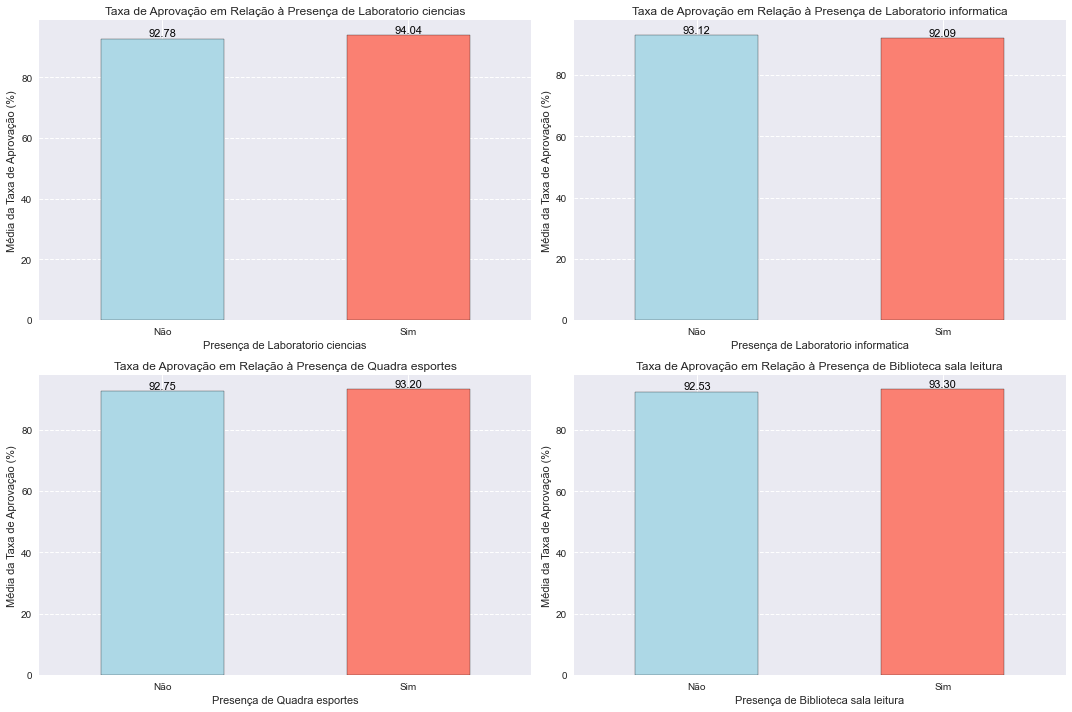

In [45]:
# Gráfico de Barras da Infraestrutura Escolar:
infra_cols = ['laboratorio_ciencias', 'laboratorio_informatica', 'quadra_esportes', 'biblioteca_sala_leitura']

# Configura a figura com 2 linhas e 2 colunas
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()  # Converte para uma lista para facilitar o loop

# Loop através de cada variável de infraestrutura e plota o gráfico de barras
for i, col in enumerate(infra_cols):
    grouped_data = gold_df.groupby(col)['taxa_aprovacao_ef'].mean()

    bars = grouped_data.plot(kind='bar', ax=axes[i], color=['lightblue', 'salmon'], edgecolor='black')
    axes[i].set_xlabel(f'Presença de {col.replace("_", " ").capitalize()}')
    axes[i].set_ylabel('Média da Taxa de Aprovação (%)')
    axes[i].set_title(f'Taxa de Aprovação em Relação à Presença de {col.replace("_", " ").capitalize()}')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Não', 'Sim'], rotation=0)
    axes[i].grid(axis='y', linestyle='--')

    # Adicionar o valor em cima de cada barra
    for bar in bars.patches:
        axes[i].annotate(format(bar.get_height(), '.2f'),
                         (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                         ha='center', va='bottom', fontsize=11, color='black')

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

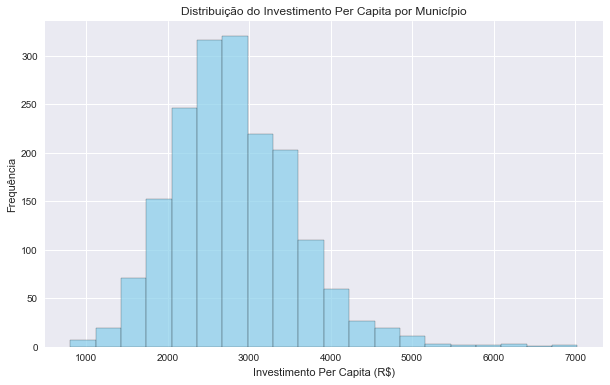

In [46]:
# Histograma de Investimento per capita
# Agrupar por município e calcular a média do investimento per capita
df_histograma = gold_df.groupby('id_municipio')['investimento_per_capita'].mean().reset_index()

# Plotar o histograma com o valor médio por município
plt.figure(figsize=(10, 6))
plt.hist(df_histograma['investimento_per_capita'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Investimento Per Capita (R$)')
plt.ylabel('Frequência')
plt.title('Distribuição do Investimento Per Capita por Município')
plt.show()

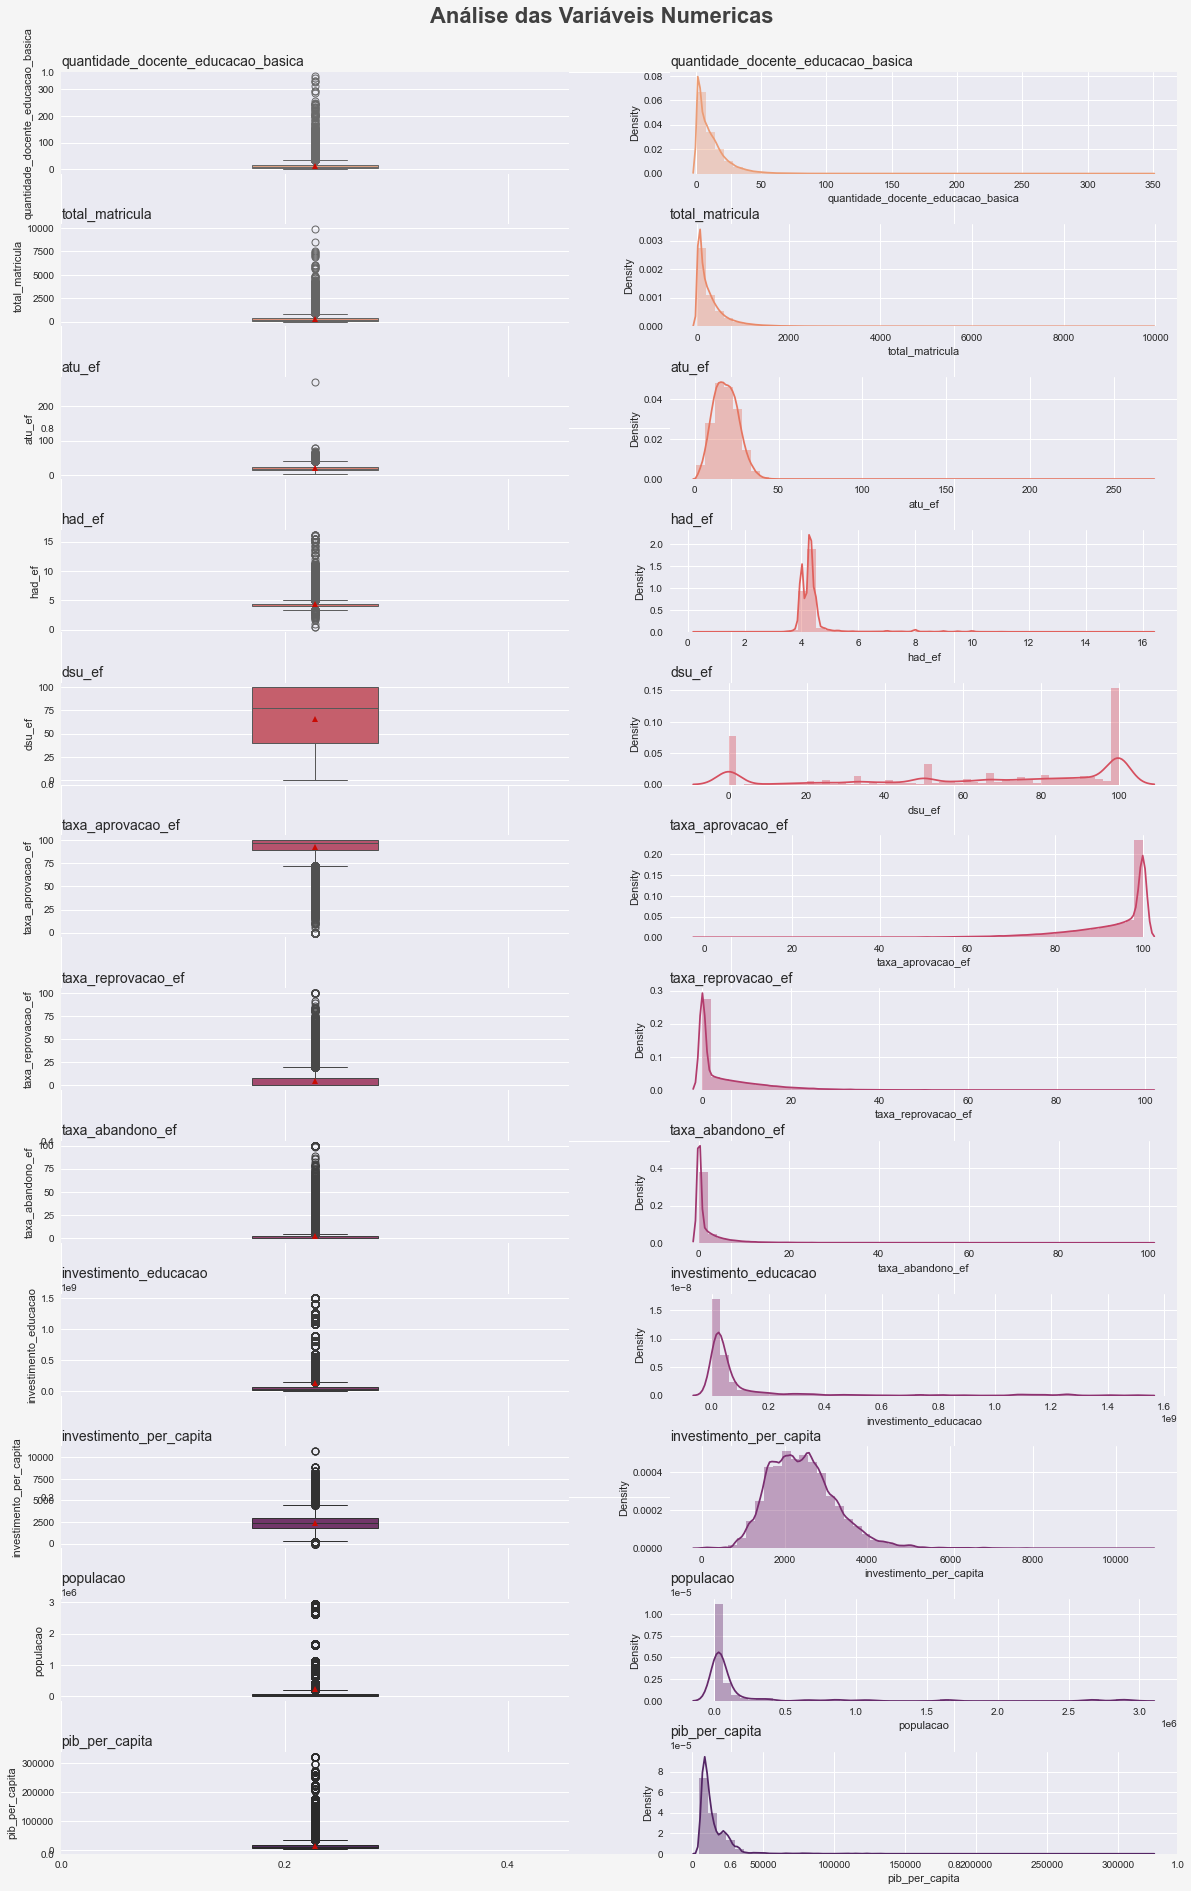

In [47]:
# Grid - Gráficos

# Converter Colunas Numericas para uma lista, para remover campos que não serão avaliados
lista_numerica = list(Colunas_Numericas)

# Valores que você quer remover
valores_para_remover = ['ano', 'id_municipio', 'id_escola']

# Converter de volta para um Index, se necessário
Colunas_Numericas_Filtradas = pd.Index([col for col in lista_numerica if col not in valores_para_remover])

# Tamanho
Figura, Eixo = plt.subplots( figsize=(20, 30) )

# Cor de fundo
Cor_Fundo = '#f5f5f5'
Figura.set_facecolor( Cor_Fundo )

# Paleta de Cores
Paleta_Cores = sns.color_palette( 'flare', len(Colunas_Numericas_Filtradas) * 2 )

# Titulo
plt.suptitle('Análise das Variáveis Numericas', fontsize=22, color='#404040', fontweight=600 )

# Estrutura
Linhas = len( Colunas_Numericas_Filtradas ) # (Todas as infos numericas)
Colunas = 2 #( Boxplot - Distplot)
Posicao = 1 # Posicao inicial do grid

# Loop para plotar os gráficos
for Coluna in Colunas_Numericas_Filtradas:

  # Plot no Grid -- Boxplot
  plt.subplot( Linhas, Colunas, Posicao )

  # Titulo
  plt.title( f'{Coluna}', loc='left', fontsize=14, fontweight=200 )

  # Plot
  sns.boxplot( data=gold_df, y=Coluna, showmeans=True, saturation=0.75, 
              linewidth=1, color=Paleta_Cores[Posicao], width=0.25 )

  # Mudar
  Posicao += 1

  # Plot no Grid -- Distplot
  plt.subplot( Linhas, Colunas, Posicao )

  # Titulo
  plt.title( f'{Coluna}', loc='left', fontsize=14, fontweight=200 )

  # Plot
  sns.distplot( gold_df[Coluna], color=Paleta_Cores[ Posicao - 1 ] )

  # Mudar
  Posicao += 1

# Ajute de Grid
plt.subplots_adjust( top=0.95, hspace=0.5 )

In [48]:
# Analisando as variáveis
gold_df['investimento_per_capita'].describe()

count   241,423.00
mean      2,438.63
std         828.07
min           0.07
25%       1,836.54
50%       2,366.19
75%       2,911.84
max      10,719.65
Name: investimento_per_capita, dtype: float64

In [49]:
gold_df['populacao'].describe()

count     241,423.00
mean      242,087.08
std       601,556.50
min         1,228.00
25%        16,970.00
50%        33,503.00
75%        88,321.00
max     2,953,986.00
Name: populacao, dtype: float64

In [50]:
gold_df['investimento_educacao'].describe()

count         241,423.00
mean      120,926,898.09
std       264,743,005.58
min               293.00
25%        15,500,990.10
50%        29,238,980.79
75%        68,192,061.99
max     1,498,453,465.19
Name: investimento_educacao, dtype: float64

In [51]:
gold_df['pib_per_capita'].describe()

count   241,423.00
mean     15,732.53
std      15,657.33
min       4,475.19
25%       8,399.60
50%      11,216.08
75%      18,949.73
max     321,810.96
Name: pib_per_capita, dtype: float64

In [52]:
gold_df['quantidade_docente_educacao_basica'].describe()

count   241,423.00
mean         11.90
std          12.41
min           1.00
25%           3.00
50%           8.00
75%          16.00
max         348.00
Name: quantidade_docente_educacao_basica, dtype: float64

In [53]:
gold_df['total_matricula'].describe()

count   241,423.00
mean        290.09
std         353.71
min           1.00
25%          59.00
50%         170.00
75%         386.00
max       9,886.00
Name: total_matricula, dtype: float64

In [54]:
gold_df['atu_ef'].describe()

count   241,423.00
mean         18.63
std           7.46
min           1.00
25%          13.00
50%          18.20
75%          23.80
max         272.00
Name: atu_ef, dtype: float64

In [55]:
gold_df['had_ef'].describe()

count   241,423.00
mean          4.41
std           0.83
min           0.40
25%           4.00
50%           4.30
75%           4.40
max          16.20
Name: had_ef, dtype: float64

In [56]:
gold_df['dsu_ef'].describe()

count   241,423.00
mean         65.51
std          36.19
min           0.00
25%          40.00
50%          77.80
75%         100.00
max         100.00
Name: dsu_ef, dtype: float64

In [57]:
gold_df['taxa_abandono_ef'].describe()

count   241,423.00
mean          1.92
std           5.05
min           0.00
25%           0.00
50%           0.00
75%           1.80
max         100.00
Name: taxa_abandono_ef, dtype: float64

In [58]:
gold_df['taxa_aprovacao_ef'].describe()

count   241,423.00
mean         92.85
std          10.08
min           0.00
25%          88.90
50%          97.20
75%         100.00
max         100.00
Name: taxa_aprovacao_ef, dtype: float64

In [59]:
# Aplicação de Escalonamento Logarítmico para ajuste de outliers populacionais e/ou quantitativos 
# que podem ter alta variação em alguns municípios
gold_df['investimento_per_capita_log'] = np.log1p(gold_df['investimento_per_capita'])  # log(x + 1) para lidar com valores zero
gold_df['populacao_log'] = np.log1p(gold_df['populacao'])  # log(x + 1) para lidar com valores zero
gold_df['investimento_educacao_log'] = np.log1p(gold_df['investimento_educacao'])
gold_df['pib_per_capita_log'] = np.log1p(gold_df['pib_per_capita'])
gold_df['quantidade_docente_educacao_basica_log'] = np.log1p(gold_df['quantidade_docente_educacao_basica'])
gold_df['total_matricula_log'] = np.log1p(gold_df['total_matricula'])

In [60]:
# Aplicando winsorização nas variáveis atu_ef e had_ef
gold_df['atu_ef_winsor'] = mstats.winsorize(gold_df['atu_ef'], limits=[0.01, 0.01])
gold_df['had_ef_winsor'] = mstats.winsorize(gold_df['had_ef'], limits=[0.01, 0.01])
gold_df['dsu_ef_winsor'] = mstats.winsorize(gold_df['dsu_ef'], limits=[0.01, 0.01])
# Winsorização da taxa de abandono
gold_df['taxa_abandono_ef_winsor'] = mstats.winsorize(gold_df['taxa_abandono_ef'], limits=[0, 0.01])

## Engenharia de Features

In [61]:
# Ajuste das colunas Categóricas
# Converter variáveis categóricas para numéricas para a análise de correlação
label_encoder = LabelEncoder()
for col in ['sigla_uf', 'rede', 'tipo_localizacao', 'laboratorio_ciencias',
            'laboratorio_informatica', 'quadra_esportes', 'biblioteca_sala_leitura',
             'regiao']:
    gold_df[col] = label_encoder.fit_transform(gold_df[col])

In [62]:
# remove a coluna nome do municipio por não inlfuenciar no modelo
gold_df.drop( columns=['municipio'], inplace=True)

In [63]:
gold_df

,ano,sigla_uf,id_municipio,id_escola,rede,tipo_localizacao,quantidade_docente_educacao_basica,laboratorio_ciencias,laboratorio_informatica,quadra_esportes,biblioteca_sala_leitura,total_matricula,atu_ef,had_ef,dsu_ef,taxa_aprovacao_ef,taxa_reprovacao_ef,taxa_abandono_ef,investimento_educacao,investimento_per_capita,regiao,populacao,pib_per_capita,investimento_per_capita_log,populacao_log,investimento_educacao_log,pib_per_capita_log,quantidade_docente_educacao_basica_log,total_matricula_log,atu_ef_winsor,had_ef_winsor,dsu_ef_winsor,taxa_abandono_ef_winsor
0,2021,3,2100600,21091439,2,0,1,0,0,0,0,101,7.20,3.80,57.10,78.10,12.30,9.60,"38,639,370.74","3,138.35",0,42017,"9,250.85",8.05,10.65,17.47,9.13,0.69,4.62,7.20,3.80,57.10,9.60
1,2021,3,2100600,21193109,0,0,13,0,0,0,0,34,5.30,3.80,18.20,58.60,34.50,6.90,"38,639,370.74","3,138.35",0,42017,"9,250.85",8.05,10.65,17.47,9.13,2.64,3.56,5.30,3.80,18.20,6.90
2,2021,3,2100600,21193110,0,0,14,0,0,0,0,72,7.30,3.80,50.00,92.00,0.00,8.00,"38,639,370.74","3,138.35",0,42017,"9,250.85",8.05,10.65,17.47,9.13,2.71,4.29,7.30,3.80,50.00,8.00
3,2021,3,2100808,21136424,2,0,3,0,0,0,0,163,14.50,6.00,44.40,100.00,0.00,0.00,"22,208,089.94","3,632.93",0,16054,"9,289.46",8.20,9.68,16.92,9.14,1.39,5.10,14.50,6.00,44.40,0.00
4,2021,3,2100808,21136785,2,0,10,0,1,0,0,589,25.00,5.90,35.30,100.00,0.00,0.00,"22,208,089.94","3,632.93",0,16054,"9,289.46",8.20,9.68,16.92,9.14,2.40,6.38,25.00,5.90,35.30,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241418,2019,5,2614105,26029901,3,1,27,1,0,0,1,712,33.90,4.50,75.00,98.80,1.20,0.00,"21,728,543.37","2,099.78",0,35907,"15,470.55",7.65,10.49,16.89,9.65,3.33,6.57,33.90,4.50,75.00,0.00
241419,2019,5,2609600,26137190,3,1,34,0,1,1,1,1096,25.30,4.10,75.90,98.70,1.30,0.00,"136,765,082.95","1,147.82",0,392482,"14,075.44",7.05,12.88,18.73,9.55,3.56,7.00,25.30,4.10,75.90,0.00
241420,2019,3,2107506,21008426,2,0,16,0,0,0,1,316,23.80,4.00,92.90,95.30,4.70,0.00,"90,407,081.77","2,151.01",0,122197,"8,109.44",7.67,11.71,18.32,9.00,2.83,5.76,23.80,4.00,92.90,0.00
241421,2019,2,2312007,23024194,2,0,14,0,0,0,1,339,19.80,4.00,100.00,97.80,1.60,0.60,"25,345,393.68","2,711.32",0,32452,"7,087.05",7.91,10.39,17.05,8.87,2.71,5.83,19.80,4.00,100.00,0.60


In [64]:
# define as colunas que irão compor as features
features_selecionadas = ['rede', 'tipo_localizacao', 'laboratorio_ciencias', 'laboratorio_informatica', 
                         'quadra_esportes', 'biblioteca_sala_leitura', 'total_matricula_log', 'investimento_per_capita_log', 
                         'pib_per_capita_log', 'investimento_educacao_log', 'quantidade_docente_educacao_basica_log', 'populacao_log',
                         'taxa_abandono_ef_winsor', 'atu_ef_winsor', 'had_ef_winsor', 'dsu_ef_winsor',  
                         'regiao']

In [65]:
# Separando as features (X) e a variável-alvo (y) para previsão de taxa de aprovação
Caracteristicas = gold_df[features_selecionadas]
Previsor = gold_df['taxa_aprovacao_ef']

# VErificar
Caracteristicas.shape, Previsor.shape

((241423, 17), (241423,))

In [66]:
# Dados das features
Caracteristicas.head()

,rede,tipo_localizacao,laboratorio_ciencias,laboratorio_informatica,quadra_esportes,biblioteca_sala_leitura,total_matricula_log,investimento_per_capita_log,pib_per_capita_log,investimento_educacao_log,quantidade_docente_educacao_basica_log,populacao_log,taxa_abandono_ef_winsor,atu_ef_winsor,had_ef_winsor,dsu_ef_winsor,regiao
0,2,0,0,0,0,0,4.62,8.05,9.13,17.47,0.69,10.65,9.60,7.20,3.80,57.10,0
1,0,0,0,0,0,0,3.56,8.05,9.13,17.47,2.64,10.65,6.90,5.30,3.80,18.20,0
2,0,0,0,0,0,0,4.29,8.05,9.13,17.47,2.71,10.65,8.00,7.30,3.80,50.00,0
3,2,0,0,0,0,0,5.10,8.20,9.14,16.92,1.39,9.68,0.00,14.50,6.00,44.40,0
4,2,0,0,1,0,0,6.38,8.20,9.14,16.92,2.40,9.68,0.00,25.00,5.90,35.30,0


In [67]:
# Dados do Previsor (variável-alvo)
Previsor.head()

0    78.10
1    58.60
2    92.00
3   100.00
4   100.00
Name: taxa_aprovacao_ef, dtype: float64

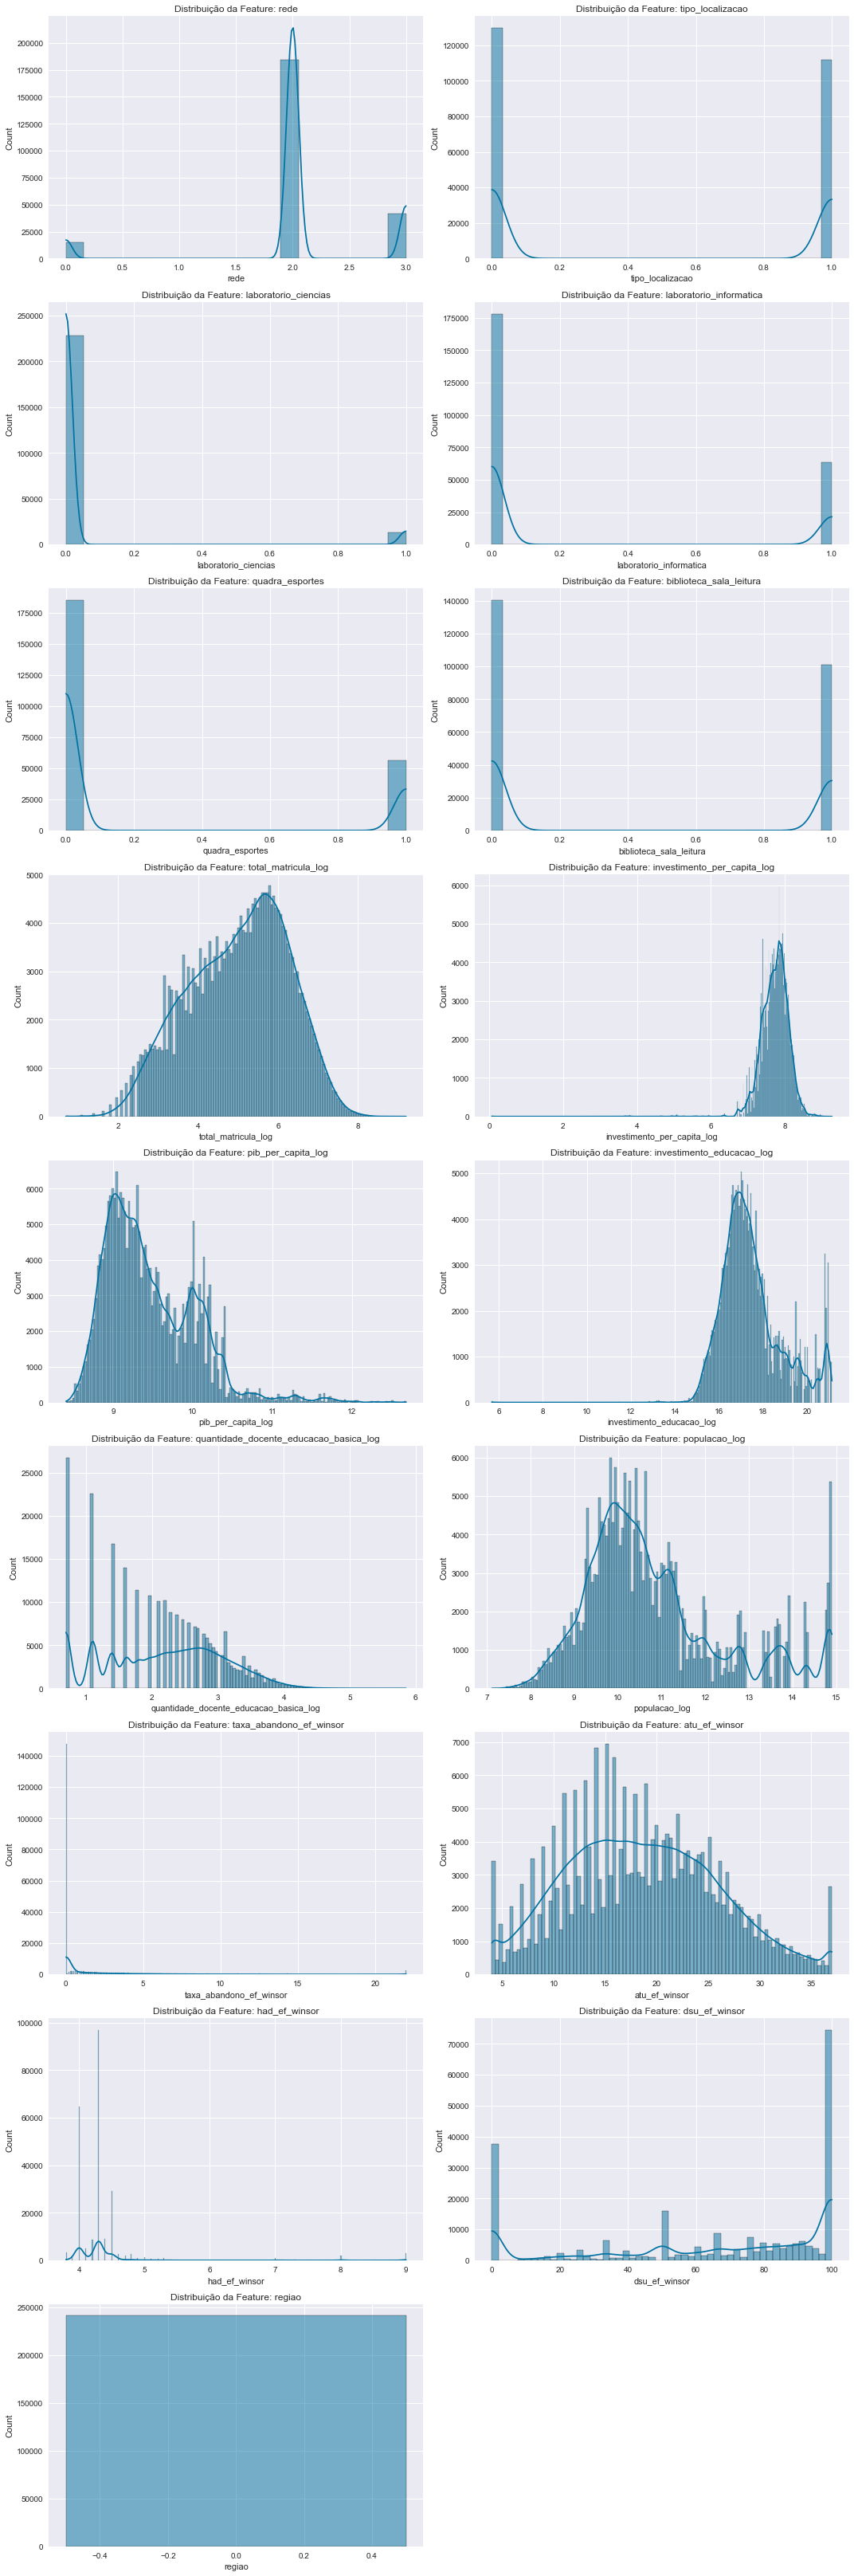

In [68]:
# Definir o número de linhas e colunas para os gráficos
num_features = len(features_selecionadas)
num_cols = 2
num_rows = math.ceil(num_features / num_cols)

# Criar a grade de subplots com o número adequado de linhas e colunas
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()

# Loop para gerar os gráficos
for i, feature in enumerate(features_selecionadas):
    sns.histplot(gold_df[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribuição da Feature: {feature}')

# Remover quaisquer eixos não utilizados, se houver
for i in range(len(features_selecionadas), len(axes)):
    fig.delaxes(axes[i])

# Ajustar o layout para evitar sobreposição de elementos
plt.tight_layout()
plt.show()

In [71]:
# Armazenar resultados
correlation_results = {}

# Teste de normalidade para o previsor
normal_test_previsor = normaltest(Previsor)
previsor_is_normal = normal_test_previsor.pvalue > 0.05

# Iterar sobre cada feature
for feature in Caracteristicas:  
    normal_test_feature = normaltest(gold_df[feature])
    feature_is_normal = normal_test_feature.pvalue > 0.05

    # Escolher o tipo de correlação
    if previsor_is_normal and feature_is_normal:
        # Usar Pearson se ambos forem normais
        correlation, p_value = pearsonr(gold_df[feature], Previsor)
        method = "Pearson"
    else:
        # Usar Spearman caso contrário
        correlation, p_value = spearmanr(gold_df[feature], Previsor)
        method = "Spearman"
    
    # Armazenar o resultado
    correlation_results[feature] = {'correlation': correlation, 'p_value': p_value, 'method': method}

# Converter os resultados para um DataFrame para visualização
correlation_df = pd.DataFrame(correlation_results).T
correlation_df

,correlation,p_value,method
rede,0.15,0.00,Spearman
tipo_localizacao,-0.04,0.00,Spearman
laboratorio_ciencias,0.00,0.99,Spearman
laboratorio_informatica,-0.10,0.00,Spearman
quadra_esportes,-0.03,0.00,Spearman
biblioteca_sala_leitura,-0.02,0.00,Spearman
total_matricula_log,-0.18,0.00,Spearman
investimento_per_capita_log,0.12,0.00,Spearman
pib_per_capita_log,0.06,0.00,Spearman
investimento_educacao_log,0.03,0.00,Spearman


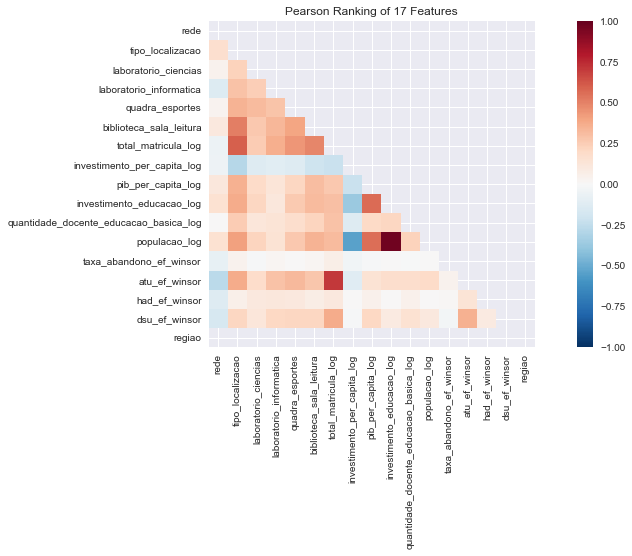

In [72]:
# Yellowbrick
# Definir o metodo
Correlacao = Rank2D( algoritmo='spearman' )

# Fitar função
Correlacao.fit( Caracteristicas, Previsor )
Correlacao.transform( Caracteristicas )
Correlacao.show();

In [73]:
# Dividindo os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(Caracteristicas, Previsor, test_size=0.2, random_state=42)

print(f'Dados de Treino: { X_train.shape[0] }')
print(f'Dados de Teste: { X_test.shape[0] }')

Dados de Treino: 193138
Dados de Teste: 48285


In [74]:
# Features mais relevantes
# Selecao de features
def Selecao_Features( X_train, y_train ):

  # Configurar para selecionar as features
  Selecao = SelectKBest( score_func=mutual_info_regression, k=5 )

  # Fitar o aprendizado
  Selecao.fit( X_train, y_train )

  return Selecao

# Aplicar essa função
Scores = Selecao_Features( X_train, y_train )

# Analisar
for Posicao, Score in enumerate( Scores.scores_ ):
  print( f' { X_train.columns[Posicao] } : {Score}' )

 rede : 0.05325704383042229
 tipo_localizacao : 0.06148522279325919
 laboratorio_ciencias : 0.013304961513381564
 laboratorio_informatica : 0.023004118262451634
 quadra_esportes : 0.03245624273923964
 biblioteca_sala_leitura : 0.036891488991871224
 total_matricula_log : 0.202586513588348
 investimento_per_capita_log : 0.1262234182758979
 pib_per_capita_log : 0.13252066137783824
 investimento_educacao_log : 0.12673186963748684
 quantidade_docente_educacao_basica_log : 0.013417617121287861
 populacao_log : 0.12891013285766384
 taxa_abandono_ef_winsor : 0.7575222743560657
 atu_ef_winsor : 0.21121048046012003
 had_ef_winsor : 0.07278339471571371
 dsu_ef_winsor : 0.08848263601797512
 regiao : 0.0


## Construção do Modelo

### *Regressão Linear*

In [75]:
resultados = {}

In [76]:
# Prever a taxa de aprovação (Regressão Linear)
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [77]:
# Prevendo no conjunto de teste
y_pred_lr = model_lr.predict(X_test)

In [78]:
# Avaliando o modelo
rmse = sqrt(mean_squared_error( y_test, y_pred_lr ) )
mse = mean_squared_error(y_test, y_pred_lr)
mae = mean_absolute_error(y_test, y_pred_lr)
r2 = r2_score( y_test, y_pred_lr )

print(f'RMSE Regressão Linear: {rmse:.2f} ')
print(f'MSE Regressão Linear: {mse:.2f} ')
print(f'MAE Regressão Linear: {mae:.2f} ')
print(f'Score Regressão Linear: {r2:.2f} ')

RMSE Regressão Linear: 7.88 
MSE Regressão Linear: 62.08 
MAE Regressão Linear: 5.48 
Score Regressão Linear: 0.40 


In [79]:
# Aplicando Cross-Validation
cv_scores_lr = cross_val_score(model_lr, Caracteristicas, Previsor, cv=5, scoring='neg_mean_squared_error')
print("CV MSE Regressão Linear: %0.2f (+/- %0.2f)" % (cv_scores_lr.mean(), cv_scores_lr.std() * 2))

CV MSE Regressão Linear: -62.28 (+/- 12.00)


In [80]:
resultados['Regressão Linear'] = {'RMSE': rmse, 'MSE': mse, 'MAE': mae, 'R2': r2, 'CVMSE': cv_scores_lr.mean()}

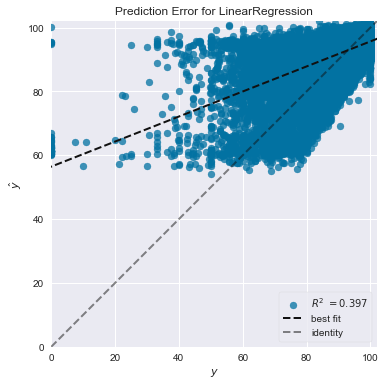

In [81]:
# Avaliando Yellowbrick
# Instanciar
Modelo = LinearRegression()
Erro_Modelo = PredictionError( Modelo )

# Fitar
Erro_Modelo.fit( X_train, y_train )
Erro_Modelo.score( X_test, y_test )
Erro_Modelo.show();

### *Árvore de Decissão*

In [82]:
# Explicação das variáveis (Árvore de Decisão)
model_dt = DecisionTreeRegressor(max_depth=5, random_state=42)
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [83]:
# Prevendo no conjunto de teste
y_pred_dt = model_dt.predict(X_test)

In [84]:
# Avaliando o modelo
rmse = sqrt(mean_squared_error( y_test, y_pred_dt ) )
mse = mean_squared_error(y_test, y_pred_dt)
mae = mean_absolute_error(y_test, y_pred_dt)
r2 = r2_score( y_test, y_pred_dt )

print(f'RMSE Árvore de Decisão: {rmse:.2f} ')
print(f'MSE Árvore de Decisão: {mse:.2f} ')
print(f'MAE Árvore de Decisão: {mae:.2f} ')
print(f'Score Árvore de Decisão: {r2:.2f} ')

RMSE Árvore de Decisão: 7.75 
MSE Árvore de Decisão: 59.99 
MAE Árvore de Decisão: 5.30 
Score Árvore de Decisão: 0.42 


In [85]:
# Aplicando Cross-Validation
cv_scores_dt = cross_val_score(model_dt, Caracteristicas, Previsor, cv=5, scoring='neg_mean_squared_error')
print("CV MSE Árvore de Decisão: %0.2f (+/- %0.2f)" % (cv_scores_dt.mean(), cv_scores_dt.std() * 2))

CV MSE Árvore de Decisão: -60.70 (+/- 11.31)


In [86]:
resultados['Árvore de Decisão'] = {'RMSE': rmse, 'MSE': mse, 'MAE': mae, 'R2': r2, 'CVMSE': cv_scores_dt.mean()}

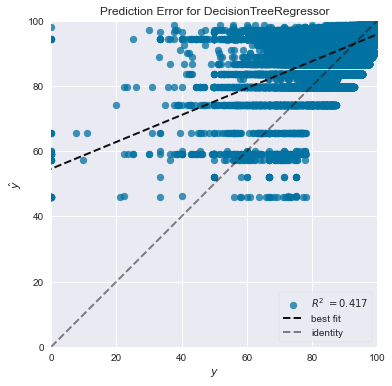

In [87]:
# Avaliando Yellowbrick
# Instanciar
Modelo = DecisionTreeRegressor(max_depth=5, random_state=42)
Erro_Modelo = PredictionError( Modelo )

# Fitar
Erro_Modelo.fit( X_train, y_train )
Erro_Modelo.score( X_test, y_test )
Erro_Modelo.show();

In [88]:
# Visualizando a importância das variáveis
importances_dt = model_dt.feature_importances_
features = Caracteristicas.columns
indices = np.argsort(importances_dt)[::-1]

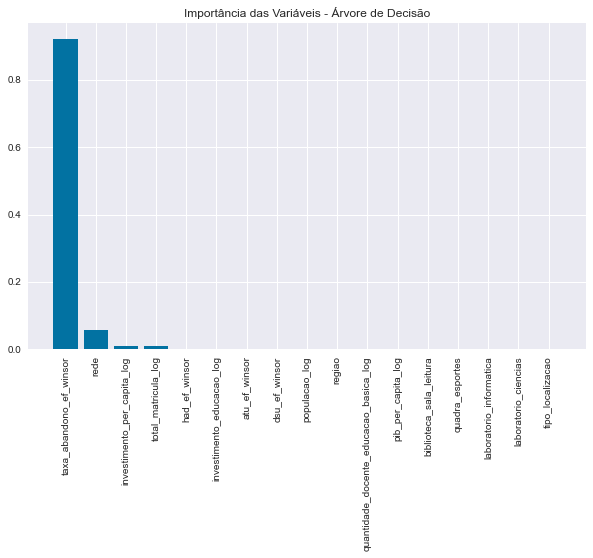

In [89]:
plt.figure(figsize=(10, 6))
plt.title("Importância das Variáveis - Árvore de Decisão")
plt.bar(range(Caracteristicas.shape[1]), importances_dt[indices], align="center")
plt.xticks(range(Caracteristicas.shape[1]), features[indices], rotation=90)
plt.show()

### *Random Forest Regressor*

In [90]:
# Instanciar
model_forest = RandomForestRegressor( max_depth=5 )

# Fitar 
model_forest.fit( X_train, y_train )

RandomForestRegressor(max_depth=5)

In [91]:
# Avaliar a performance
y_pred_rfr = model_forest.predict( X_test )

rmse = sqrt(mean_squared_error( y_test, y_pred_rfr ) )
mse = mean_squared_error(y_test, y_pred_rfr)
mae = mean_absolute_error(y_test, y_pred_rfr)
r2 = r2_score( y_test, y_pred_rfr )

print(f'RMSE Random Forest: {rmse:.2f} ')
print(f'MSE Random Forest: {mse:.2f}')
print(f'MAE Random Forest: {mae:.2f}')
print(f'Score Random Forest: {r2:.2f} ')

RMSE Random Forest: 7.71 
MSE Random Forest: 59.46
MAE Random Forest: 5.28
Score Random Forest: 0.42 


In [92]:
# Aplicando Cross-Validation
cv_scores_rfr = cross_val_score(model_forest, Caracteristicas, Previsor, cv=5, scoring='neg_mean_squared_error')
print("CV MSE Random Forest : %0.2f (+/- %0.2f)" % (cv_scores_rfr.mean(), cv_scores_rfr.std() * 2))

CV MSE Random Forest : -60.08 (+/- 11.20)


In [93]:
resultados['Random Forest'] = {'RMSE': rmse, 'MSE': mse, 'MAE': mae, 'R2': r2, 'CVMSE': cv_scores_rfr.mean()}

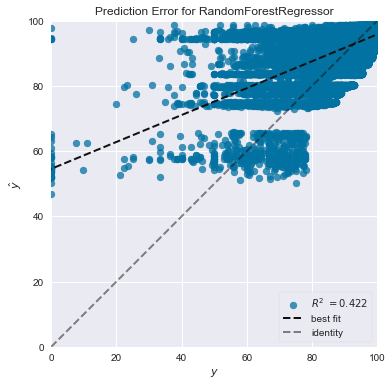

In [94]:
# Avaliando Yellowbrick
# Instanciar
Modelo = RandomForestRegressor( max_depth=5 )
Erro_Modelo = PredictionError( Modelo )

# Fitar
Erro_Modelo.fit( X_train, y_train )
Erro_Modelo.score( X_test, y_test )
Erro_Modelo.show();

In [95]:
# Visualizando a importância das variáveis
importances_rfr = model_forest.feature_importances_
features = Caracteristicas.columns
indices = np.argsort(importances_rfr)[::-1]

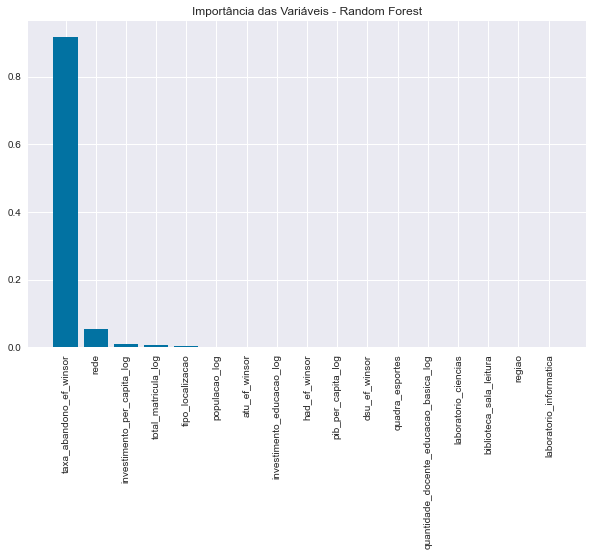

In [96]:
plt.figure(figsize=(10, 6))
plt.title("Importância das Variáveis - Random Forest")
plt.bar(range(Caracteristicas.shape[1]), importances_rfr[indices], align="center")
plt.xticks(range(Caracteristicas.shape[1]), features[indices], rotation=90)
plt.show()

### *Gradient Boosting*

In [97]:
# Instanciar
model_gbr = GradientBoostingRegressor( max_depth=5, random_state=42 )

# Fitar 
model_gbr.fit( X_train, y_train )

GradientBoostingRegressor(max_depth=5, random_state=42)

In [98]:
# Prevendo no conjunto de teste
y_pred_gbr = model_gbr.predict(X_test)

In [99]:
# Avaliando o modelo
rmse = sqrt(mean_squared_error( y_test, y_pred_gbr ) )
mse = mean_squared_error(y_test, y_pred_gbr)
mae = mean_absolute_error(y_test, y_pred_gbr)
r2 = r2_score( y_test, y_pred_gbr )

print(f'RMSE Gradient Boosting: {rmse:.2f} ')
print(f'MSE Gradient Boosting: {mse:.2f} ')
print(f'MAE Gradient Boosting: {mae:.2f} ')
print(f'Score Gradient Boosting: {r2:.2f} ')

RMSE Gradient Boosting: 7.38 
MSE Gradient Boosting: 54.43 
MAE Gradient Boosting: 4.94 
Score Gradient Boosting: 0.47 


In [100]:
# Aplicando Cross-Validation
cv_scores_gbr = cross_val_score(model_gbr, Caracteristicas, Previsor, cv=5, scoring='neg_mean_squared_error')
print("CV MSE Gradient Boosting: %0.2f (+/- %0.2f)" % (cv_scores_gbr.mean(), cv_scores_gbr.std() * 2))

CV MSE Gradient Boosting: -55.48 (+/- 9.55)


In [101]:
resultados['Gradient Boosting'] = {'RMSE': rmse, 'MSE': mse, 'MAE': mae, 'R2': r2, 'CVMSE': cv_scores_gbr.mean()}

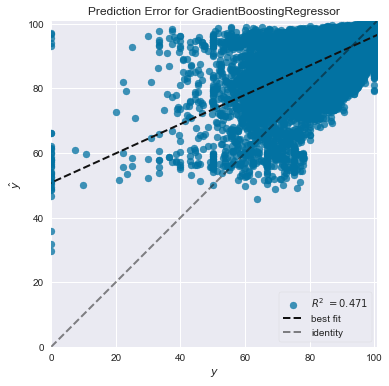

In [102]:
# Avaliando Yellowbrick
# Instanciar
Modelo = GradientBoostingRegressor( max_depth=5, random_state=42 )
Erro_Modelo = PredictionError( Modelo )

# Fitar
Erro_Modelo.fit( X_train, y_train )
Erro_Modelo.score( X_test, y_test )
Erro_Modelo.show();

In [103]:
# Visualizando a importância das variáveis
importances_gbr = model_gbr.feature_importances_
features = Caracteristicas.columns
indices = np.argsort(importances_gbr)[::-1]

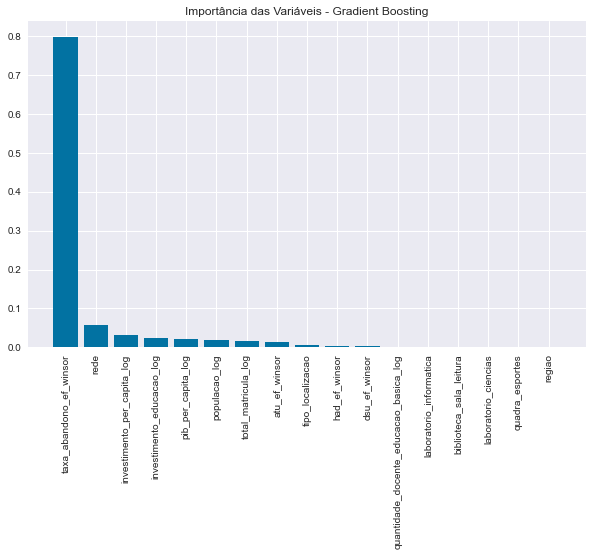

In [104]:
plt.figure(figsize=(10, 6))
plt.title("Importância das Variáveis - Gradient Boosting")
plt.bar(range(Caracteristicas.shape[1]), importances_gbr[indices], align="center")
plt.xticks(range(Caracteristicas.shape[1]), features[indices], rotation=90)
plt.show()

### *XGBoost*

In [105]:
# Instanciar
model_xgb = xgb.XGBRegressor(max_depth=5)

# Treinando o modelo
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [106]:
# Fazendo previsões
y_pred_xgb = model_xgb.predict(X_test)

In [107]:
# Avaliando o modelo
rmse = sqrt(mean_squared_error( y_test, y_pred_xgb ) )
mse = mean_squared_error(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score( y_test, y_pred_xgb )

print(f'RMSE XGBoost: {rmse:.2f} ')
print(f'MSE XGBoost: {mse:.2f} ')
print(f'MAE XGBoost: {mae:.2f} ')
print(f'Score XGBoost: {r2:.2f} ')

RMSE XGBoost: 7.17 
MSE XGBoost: 51.34 
MAE XGBoost: 4.74 
Score XGBoost: 0.50 


In [108]:
# Aplicando Cross-Validation
cv_scores_xgb = cross_val_score(model_xgb, Caracteristicas, Previsor, cv=5, scoring='neg_mean_squared_error')
print("CV MSE XGBoost: %0.2f (+/- %0.2f)" % (cv_scores_xgb.mean(), cv_scores_xgb.std() * 2))

CV MSE XGBoost: -53.20 (+/- 8.66)


In [109]:
resultados['XGBoost'] = {'RMSE': rmse, 'MSE': mse, 'MAE': mae, 'R2': r2, 'CVMSE': cv_scores_xgb.mean()}

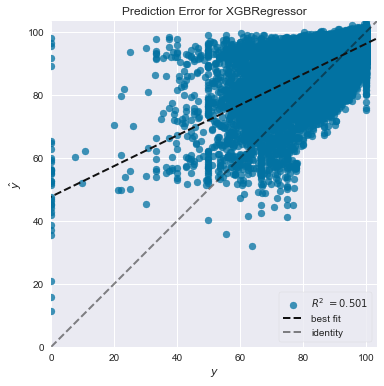

In [110]:
# Avaliando Yellowbrick
# Instanciar
Modelo = xgb.XGBRegressor(max_depth=5)
Erro_Modelo = PredictionError( Modelo )

# Fitar
Erro_Modelo.fit( X_train, y_train )
Erro_Modelo.score( X_test, y_test )
Erro_Modelo.show();

In [111]:
# Visualizando a importância das variáveis
importances_xgb = model_xgb.feature_importances_
features = Caracteristicas.columns
indices = np.argsort(importances_xgb)[::-1]

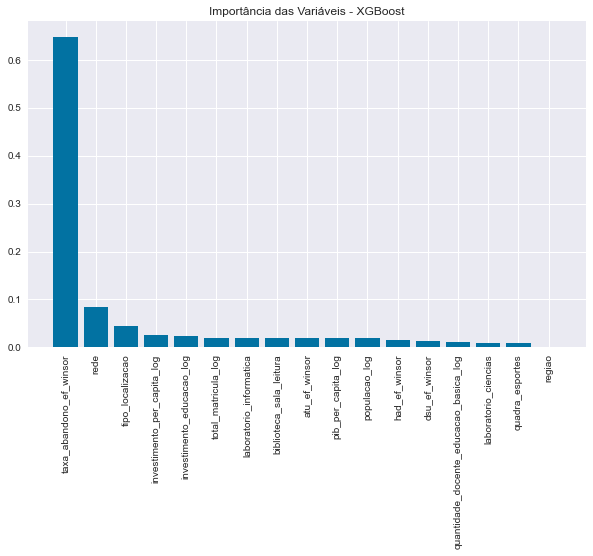

In [112]:
plt.figure(figsize=(10, 6))
plt.title("Importância das Variáveis - XGBoost")
plt.bar(range(Caracteristicas.shape[1]), importances_xgb[indices], align="center")
plt.xticks(range(Caracteristicas.shape[1]), features[indices], rotation=90)
plt.show()

In [113]:
# Comparar os resultados
tabela_resultados = pd.DataFrame(resultados).T
print(tabela_resultados)

                   RMSE   MSE  MAE   R2  CVMSE
Regressão Linear   7.88 62.08 5.48 0.40 -62.28
Árvore de Decisão  7.75 59.99 5.30 0.42 -60.70
Random Forest      7.71 59.46 5.28 0.42 -60.08
Gradient Boosting  7.38 54.43 4.94 0.47 -55.48
XGBoost            7.17 51.34 4.74 0.50 -53.20


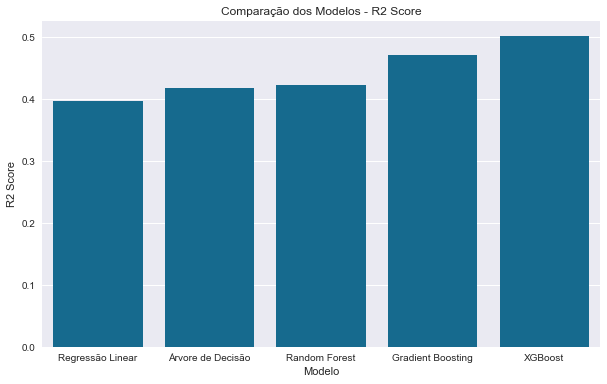

In [114]:
# Visualizar comparação dos resultados
plt.figure(figsize=(10, 6))
sns.barplot(x=tabela_resultados.index, y='R2', data=tabela_resultados)
plt.title('Comparação dos Modelos - R2 Score')
plt.ylabel('R2 Score')
plt.xlabel('Modelo')
plt.show()